https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html

In [98]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial
from typing import Any
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
from einshape import jax_einshape as einshape
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
import optax

## PyTorch
import torch
import torch.utils.data as data
#from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

import urllib.request
from urllib.error import HTTPError

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/kuhpc/work/slusky/syasna_sta/env_setup_test/attention_jax"

print("Device:", jax.devices()[0])

Device: TFRT_CPU_0


/tmp/ipykernel_29488/3893556782.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [2]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [3]:
key = jax.random.PRNGKey(0)

In [4]:
#traditional formual
def scaled_dot_product(k, q, v, mask=None): 
    d_k = k.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1)) / jnp.sqrt(d_k) #q_first_dim, k_last_dim
    #print("shape of attn_logits", attn_logits.shape)
    if mask is not None:
        attn_logits = jnp.where(mask == 0, -9e15, attn_logits)
    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values, attention

In [5]:
seq_len, d_k = 8, 5
main_rng, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (seq_len, 3, d_k)) #3,3,2
#jnp array of (seqlen, 1, 1)
mask = jax.random.bernoulli(main_rng, p=0.5, shape=(seq_len, 1, 1))
print(mask.shape)
q, k, v = qkv[0], qkv[1], qkv[2] #3,2
values, attention = scaled_dot_product(k, q, v)
print("attention", attention.shape)
print("values", values.shape)
#now do with mask
values, attention = scaled_dot_product(k, q, v, mask) #resulintg attention shape: (8, 3, 3), or mask_first_dim, attention_remaining_dims
print("attention", attention.shape)
print("values", values.shape)


(8, 1, 1)
attention (3, 3)
values (3, 5)
attention (8, 3, 3)
values (8, 3, 5)


In [6]:
#assume mask.ndim is minimum of 3
def expand_mask(mask):
    assert mask.ndim >= 2
    if mask.ndim == 3:
        mask = jnp.expand_dims(mask, 1)
      #  mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = jnp.expand_dims(mask, 0)
        # mask = mask.unsqueeze(0)
    return mask

In [7]:
class MultiHeadAttention(nn.Module):
    num_heads: int #parallel heads 
    embed_dim : int #output dim (in o_proj on values, this will be the output dim at the end)
    
    def setup(self):
        self.qkv_proj = nn.Dense(
            3 *  self.embed_dim,
            kernel_init = nn.initializers.xavier_uniform()
        )
        self.o_proj = nn.Dense(self.embed_dim,
                            kernel_init = nn.initializers.xavier_uniform())
        
    def __call__(self, 
                x,
                mask=None):
        batch_size, seq_length, embed_dim = x.shape
        if mask is not None: 
            #mask min 3 dims
            mask = expand_mask(mask) 
        #qkv as batch_size, seq_len, heads, embed_dim
        qkv = self.qkv_proj(x) #now batch_size, seq_len, 3*embed_dim    
       # print("qkv shape with out_proj as 3*embed_dim", qkv.shape)
        #split qkv into individual heads 
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1) #batch_size, seq_len, num_heads, embed_dim/num_heads (num_heads has to be evenly divisible)
        qkv = qkv.transpose(0, 2, 1, 3) #now move num_heads forward, seq_len backwards in dimensions, so now each batch is split directly by num_heads
      #  print("qkv shape after transposing batch to num_heads", qkv.shape)
        #now split qkv by last axis with overall weights
        q, k, v = jnp.array_split(qkv, 3,axis = -1)
       # print("q shape", q.shape)
        
        #apply scaled dot product attention to each and with mask 
        #batch_size, num_heads, seq_len, embed_dim/num_heads
        values, attention = scaled_dot_product(k, q, v, mask)
       # print("values shape", values.shape) 
        #concatenate values from each head
        #now reshape values so that num_heads dimension disappears and it's by sequence length per batch
        values = values.transpose(0, 2, 1, 3)  #batchsize, seq_len, num_heads, embed_dim/num_heads 
        #compress back to 3 dimensions (compress last two dimensions back to original embed_dim), batch_size, seq_len, embed_dim
        values = values.reshape(batch_size, seq_length, embed_dim) 
       # assert(values.shape == x.shape)
        #now can project over, same dimensions
        out = self.o_proj(values)
       # assert(values.shape == x.shape == out.shape)
        return out, attention

In [8]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
x.shape #3, 16, 128

mh_attn = MultiHeadAttention(embed_dim=128, num_heads=4)
main_rng, init_rng = random.split(main_rng)
params = mh_attn.init(init_rng, x)['params']
out, atten = mh_attn.apply({'params': params}, x)
print('out', out.shape, 'attention', atten.shape)

out (3, 16, 128) attention (3, 4, 16, 16)


In [9]:
class EncoderBlock(nn.Module): 
    input_dim : int #determines out dim of mha too
    num_heads : int
    dim_feedforward : int
    dropout_rate : float = 0.0
    
    
    def setup(self): 
        self.mha = MultiHeadAttention(self.num_heads, self.input_dim) 
        #MLP
        self.linear = [
            nn.Dense(self.dim_feedforward),
            #is it alright to have deterministic set here in linear, or must it be in forward?
            nn.Dropout(self.dropout_rate),
            nn.relu,
            nn.Dense(self.input_dim)
        ]
        #norm1 and norm2 initialized as separate layers otherwise will share weights 
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_rate)
    
    def __call__(self, x, mask=None, deterministic = False):
        attn_, _ = self.mha(x, mask)
        #add & norm after mha. Dropout applies during train 
        
        x = x + self.dropout(attn_, deterministic = deterministic)
        x = self.norm1(x)
        
        #x = LayerNorm(x + MLP(x)) so feedforward -> add & norm1
        linear_out = x
        for l in self.linear:
            #apply deterministic where necessary
            linear_out = l(linear_out, deterministic = deterministic) if isinstance(l, nn.Dropout) else l(linear_out)
        x = x + self.dropout(linear_out, deterministic = deterministic)
        x = self.norm2(x)
        return x

In [10]:
print("x input shape",x.shape)
#now need to init dropout too in addition to main and _init_
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
encoder_block = EncoderBlock(input_dim=x.shape[-1], num_heads=4, dim_feedforward=512, dropout_rate = 0.1)
main_rng, init_rng, dropout_rng = random.split(main_rng, 3)
params = encoder_block.init(
    {
        'params': init_rng,
        'dropout' : dropout_rng
    },
    #rest of call arguments
    x, deterministic = False
)['params'] #need to pass in params dictionary to avoid getting a nested params layer
#apply rng to forward/__call__ since dropout is stochastic
main_rng_apply, dropout_rng_apply = random.split(main_rng)  
out = encoder_block.apply({'params': params}, 
                        x, 
                        deterministic=False, 
                        rngs={'dropout': dropout_rng_apply}
                        )
assert(x.shape == out.shape)


x input shape (3, 16, 128)


In [11]:
class TransformerEncoder(nn.Module): 
    num_layers : int #num encoder layers in Encoder block
    input_dim : int #determines out dim of mha too
    num_heads : int
    dim_feedforward : int
    dropout_rate : float = 0.0
    
    def setup(self):
        #initializes train parameter from self.train in the individual encoder blocks
        self.layers = [EncoderBlock(
            input_dim = self.input_dim, 
            num_heads = self.num_heads, 
            dim_feedforward = self.dim_feedforward,
            dropout_rate = self.dropout_rate
        )
        for i in range(self.num_layers)]
        #pass dynamic deterministic variable as call argument
    def __call__(self, x, mask=None, deterministic = False):
        for layer in self.layers:
            x = layer(x, mask, deterministic = deterministic)
        return x
    
    # def get_attention_map(self, x, mask=None, train=True): 
    #     #todo visualization
    #     pass

In [12]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create Transformer encoder
transenc = TransformerEncoder(num_layers=5,
                            input_dim=128,
                            num_heads=4,
                            dim_feedforward=256,
                            dropout_rate=0.15)
# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x,  deterministic = False)['params']
#rng for stochastic dropuot too
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, deterministic = False)
print('Out', out.shape)

Out (3, 16, 128)


Positional Encodings

In [13]:
#Vaswani et all positional sinusoidal encodings:
class PositionalEncoding(nn.Module):
    #positional encodings has exponents of vars d_model and need to know max length
    d_model : int 
    max_len : int = 5000 #number of inputs
    
    def setup(self): 
        self.pe = jnp.zeros((self.max_len, self.d_model)) #(max_len, d_model) init
        position = jnp.arange(0,self.max_len, dtype=jnp.float32)[:, None] #set out position array over hte maxlen
        #division by 10000^  (i-2)*d_model
        denominator = jnp.power(
            10000.0 ,
            jnp.arange(0, self.d_model, 2) / self.d_model
        )

        #every even position is sine of position / denominator
        self.pe = self.pe.at[:, 0::2].set(jnp.sin(position / denominator))  
        self.pe = self.pe.at[:, 1::2].set(jnp.cos(position / denominator))
        #look into purpose of the pe[None] 
        self.pe = self.pe[None]
        #commit positional encoding precomputation to device
        self.pe = jax.device_put(self.pe)
    
    def __call__(self, x): 
        #pe in shape of (max_len, d_model) so x shape (batch_size, d_model, ...)
        return x + self.pe[:, :x.shape[1]]

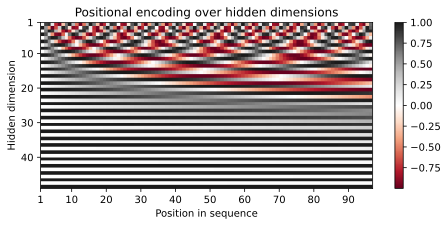

In [14]:
# Create encoding block, bind to access positional encoding (module has no parameters)
encod_block = PositionalEncoding(d_model=48, max_len=96).bind({})
# Obtain positional encodings as numpy array
pe = jax.device_get(encod_block.pe.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

In [15]:
#try RoPE embedding implementation as helper, no state management wrapper 
#compute sin and cos for each position 
@nn.nowrap
def precompute_sin_cos_exp_caches(max_len, d_model):
    #position inddices, [0.... seq_len -1]
    position = jnp.arange(0, max_len, dtype=jnp.float32)[:, None]
    #10000 ^ (-2(i-1) / d_model) for i from 1 to d_model/2
    denominator = 1. / jnp.power(
            10000.0 ,
            jnp.arange(0, d_model, 2) / d_model
        )
    #product of position and denominator
    idx_pos_denom = position * denominator
    #directly concatenate so that there is row of pos_denom_product for sin and cos individually
    idx_concat = jnp.concat([idx_pos_denom, idx_pos_denom], axis=-1)

    assert idx_concat.shape == (max_len, d_model)
    #expand middle two dimensions
    cos_cache = jnp.cos(idx_concat)
    sin_cache = jnp.sin(idx_concat)
    # cos_cache = idx_concat.cos()[:, None, None, :]
    # sin_cache = idx_concat.sin()[:, None, None, :]
    return sin_cache, cos_cache

In [16]:
#try above
max_len = 96
d_model = 48
positional_embeddings = PositionalEncoding(d_model=d_model, max_len=max_len)
sin_cache, cos_cache = precompute_sin_cos_exp_caches(max_len, d_model)


In [17]:
@nn.nowrap
#function to use on a key or query 
def rope_emb( key, query, sin_cache, cos_cache, expand_dim = 1):
    #shape: [num_heads, 1, head_dim], so first and third dimension should match key and query dimensions to broadcast
    cos_cache = jnp.expand_dims(cos_cache, axis = expand_dim)
    sin_cache = jnp.expand_dims(sin_cache, axis = expand_dim)
    assert (sin_cache.shape == cos_cache.shape)
    #split query into two partsn and rotate, with later negation of second half
    query1, query2 = jnp.split(query, 2, axis = -1)
    #[batch_size, num_heads, seq_len, head_dim]
    query_rotated = jnp.concatenate([-query2, query1], axis = -1)
    key1, key2 = jnp.split(key, 2, axis = -1)
    key_rotated = jnp.concatenate([-key2, key1], axis = -1)
    
    #apply embs to query and key splits
    query_emb = (query * cos_cache) + (query_rotated * sin_cache)
    key_emb = (key * cos_cache) + (key_rotated* sin_cache)
    return query_emb, key_emb


In [18]:
# key = random.normal(main_rng, (96, 16, 48))
# query = random.normal(main_rng, (96, 16, 48))
# query_emb, key_emb = rope_emb(key, query, sin_cache, cos_cache)
# #TODO COME BACK TO THIS

In [19]:
from typing import Any


class Transformer(nn.Module):
    model_dim : int
    num_heads : int
    num_classes : int
    num_layers : int
    dropout_rate : float = 0.0
    init_dropout_rate : float = 0.0
    
    def setup(self):
        #dropout and output model_dim size
        self.input_dropout = nn.Dropout(rate = self.init_dropout_rate)
        self.input_layer = nn.Dense(self.model_dim)
        
        #positional encoding 
        self.positional_encoding = PositionalEncoding(self.model_dim)

        self.enc = TransformerEncoder(
            num_layers = self.num_layers,
            input_dim = self.model_dim,
            num_heads = self.num_heads,
            dim_feedforward = 2 * self.model_dim,
            dropout_rate = self.dropout_rate
        )
        
        #mlp output (no decoder for now)
        self.out = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(rate = self.dropout_rate),
            nn.Dense(self.num_classes)
        ]
    
    def __call__(self, 
            x,
            mask=None,
            add_positional_encoding = True, 
            train = True):
        x = self.input_dropout(x, deterministic = not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.enc(x, mask, deterministic = not train)
        for l in self.out:
            x = l(x, deterministic = not train) if isinstance(l, nn.Dropout) else l(x)
        return x

In [20]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
transpre = Transformer(num_layers=5,
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_rate=0.15,
                                init_dropout_rate=0.05)
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)

Out (3, 16, 10)


MHA adjusted to allow rotary embs:

In [21]:
class MLA(nn.Module):
    num_heads: int
    embed_dim: int
    
    def setup(self):
        self.head_dim = self.embed_dim // self.num_heads #since should naturally project below onto oringal embed_dim
        self.query_proj = nn.Dense(
            self.num_heads * self.head_dim,
            kernel_init = nn.initializers.xavier_uniform()
        )
        self.key_proj = nn.Dense(
            #normally would project ot a reduced number of key-value heads..
            self.num_heads * self.head_dim,
            kernel_init = nn.initializers.xavier_uniform()
        )
        self.value_proj = nn.Dense(
            self.num_heads * self.head_dim,
            kernel_init=nn.initializers.xavier_uniform()
        )
    
        #final output projection of attention
        self.o_proj = nn.Dense(
            self.embed_dim,
            kernel_init = nn.initializers.xavier_uniform()
        )
    def __call__(self, x,
                sin, #position embeddings...
                cos, 
                mask=None):
        #get these for scaling reshapes below
        batch_size, seq_length, embed_dim = x.shape

        if mask is not None: 
            #mask min 3 dims
            mask = expand_mask(mask) 
            
        #shape [batch_size, seq_length, num_heads*head_dim]
        query_state = self.query_proj(x)
        key_state = self.key_proj(x)
        value_state = self.value_proj(x)
        
        #[batch_size, seq_length, num_heads*head_dim] ->
        #[batch_size, seq_length, num_heads, head_dim] ->
        #[batch_size, num_heads, seq_length, head_dim]
        query_state = query_state.reshape(
            batch_size, seq_length, self.num_heads, -1
        ).transpose(0, 2, 1, 3)
        key_state = key_state.reshape(
            batch_size, seq_length, self.num_heads, -1
        ).transpose(0, 2, 1, 3)
        value_state = value_state.reshape(
            batch_size, seq_length, self.num_heads, -1
        ).transpose(0, 2, 1, 3)
        
        #applied rope embeddings (shape maintained)
        query_state, key_state = rope_emb(query_state, 
                                        key_state, 
                                        sin, 
                                        cos, 
                                        expand_dim = 1)
        
        #scaled dot product attention with mask
        values, attention = scaled_dot_product(key_state, query_state, value_state, mask)
        
        #softmax to get attention probabilities [batch_size, num_heads, seq_length, head_dim / 2]
        attention_weights = nn.softmax(attention, axis = -1)
        #dot product of weights with values
        attn_output = jnp.matmul(attention_weights, values)
        #reshape output, compress last two dimensions for each head
        #-> [batch_size, num_heads, embed_dim]
        attn_output = attn_output.transpose(0, 2, 1, 3)
        attn_output = attn_output.reshape(batch_size, seq_length, embed_dim)
        #attn_output proj back to original shape of x: [batch_size, seq_length, embed_dim]
        #attention_weights maintains k q v state shapes: [batch_size, num_heads, seq_length, head_dim ]
        return self.o_proj(attn_output), attention_weights

In [22]:
#run on inputs
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
#get precomputed sin and cos positional embeddings
sin, cos = precompute_sin_cos_exp_caches(4, 32)
mla = MLA(num_heads=4, embed_dim=128)
main_rng, init_rng = random.split(main_rng)
params = mla.init(init_rng, x, sin, cos)['params']
attn_proj, weights = mla.apply({'params': params}, x, sin, cos)

In [23]:
class MLAEncoderBlock(nn.Module): 
    input_dim : int #determines out dim of mha too
    num_heads : int
    dim_feedforward : int
    dropout_rate : float = 0.0 
    
    
    def setup(self): 
        self.mla = MLA(self.num_heads, self.input_dim) 
        #MLP
        self.linear = [
            nn.Dense(self.dim_feedforward),
            #is it alright to have deterministic set here in linear, or must it be in forward?
            nn.Dropout(self.dropout_rate),
            nn.relu,
            nn.Dense(self.input_dim)
        ]
        #norm1 and norm2 initialized as separate layers otherwise will share weights 
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_rate)
    
    def __call__(self, x, sin, cos, 
                mask=None, deterministic = False):
        attn_, _ =self.mla(x,  sin, cos, mask)

        #add & norm after mha. Dropout applies during train 
        
        x = x + self.dropout(attn_, deterministic = deterministic)
        x = self.norm1(x)
        
        #x = LayerNorm(x + MLP(x)) so feedforward -> add & norm1
        linear_out = x
        for l in self.linear:
            #apply deterministic where necessary
            linear_out = l(linear_out, deterministic = deterministic) if isinstance(l, nn.Dropout) else l(linear_out)
        x = x + self.dropout(linear_out, deterministic = deterministic)
        x = self.norm2(x)
        return x

In [24]:
class MLATransformerEncoder(nn.Module): 
    num_layers : int #num encoder layers in Encoder block
    input_dim : int #determines out dim of mha too
    num_heads : int
    dim_feedforward : int
    dropout_rate : float = 0.0
    
    def setup(self):
        #initializes train parameter from self.train in the individual encoder blocks
        self.layers = [MLAEncoderBlock(
            input_dim = self.input_dim, 
            num_heads = self.num_heads, 
            dim_feedforward = self.dim_feedforward,
            dropout_rate = self.dropout_rate
        )
        for i in range(self.num_layers)]
        #pass dynamic deterministic variable as call argument
    def __call__(self, x, 
                sin, 
                cos, 
                mask=None, deterministic = False):
        for layer in self.layers:
            x = layer(x, sin, cos, mask, deterministic = deterministic)
        return x

In [96]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
mask = jax.random.bernoulli(main_rng, p=0.5, shape=(3, 16, 64))
#show mask as ones
transpre = MLATransformer(num_layers=5,
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_rate=0.15,
                                init_dropout_rate=0.05)
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.apply({'params': params}, x= x,  train=True, rngs={'dropout': dropout_apply_rng})
print(binded_mod.shape)

(3, 16, 10)


Simple Train For Reverse Dataset

In [99]:
DATASET_PATH = "/kuhpc/work/slusky/syasna_sta/env_setup_test/data"

In [86]:
class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = Transformer(**model_kwargs)
        # Prepare logging TODO UNCOMMENT ONCE TENSORBOARD INSTALLED
        # self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        # self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)

    def batch_to_input(self, exmp_batch):
        # Map batch to input data to the model
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def get_loss_function(self):
        # Return a function that calculates the loss for a batch
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()

        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                #self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                #self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        # self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        # self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        #checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, step=step)
        pass

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for the pretrained model
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this Transformer
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [87]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.np_rng = np_rng

        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)
        return inp_data, labels

In [88]:
# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = partial(ReverseDataset, 10, 16)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)),
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(44)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)

In [89]:
class ReverseTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _ = batch
        inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
        return inp_data

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch
            inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        return calculate_loss

In [90]:
def train_reverse(max_epochs = 10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    trainer = ReverseTrainer('MLA-Reverse', 
                            exmp_batch = next(iter(rev_train_loader)),
                            max_iters = num_train_iters,
                            **model_args
    )
    
    if not trainer.checkpoint_exists():
        trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)
        trainer.save_model()
        
    else:
        trainer.load_model(pretrained=True)

    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    #bind, inference so no dropout rng 
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [91]:
reverse_trainer, reverse_result = train_reverse(model_dim=32,
                                                num_heads=2,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=1,
                                                init_dropout_rate=0.0,
                                                dropout_rate = 0.1,
                                                lr=5e-4,
                                                warmup=50)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


In [92]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


Anomaly

In [32]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = img / 255.   # Normalization is done in the ResNet
    return img
# Resize to 224x224, and map to JAX
transform = transforms.Compose([transforms.Resize((224,224)),
                                image_to_numpy
                               ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)
# For later, keep a dictionary mapping class indices to class names
class_idx_to_name = {val: key for key, val in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [33]:
train_set.data = train_set.data[:5000]
test_set.data = test_set.data[:1000]